## ECE495 Intro to programming neurons with Nengo: Transformation

In this demonstration we will:

1. Add using a single neuron
2. Discuss decoders in more depth
3. Perform simple mathematical computations using neurons (such as squaring values)
4. Perform mathematical computations that require 2-D neurons (such as multiplication)

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.processes import Piecewise



### Addition using neurons

Do you think you need multiple neurons to add, or can a single neuron do it alone?

Inputs to a neuron ensemble are spike rates. Higher spike rates represent higher values, lower rates for lower values. If the neuron ensemble is recieving all of these spikes and passing along the info, the spike rate out is the combined rate.

Think through this: all neurons are firing at 100Hz over 1 second and you're wanting to add a value of .2 (20 spikes) to .3 (30 spikes). That means your adder neuron ensemble receives 50 spikes. What value would that decode to for a firing rate of 100Hz?? 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

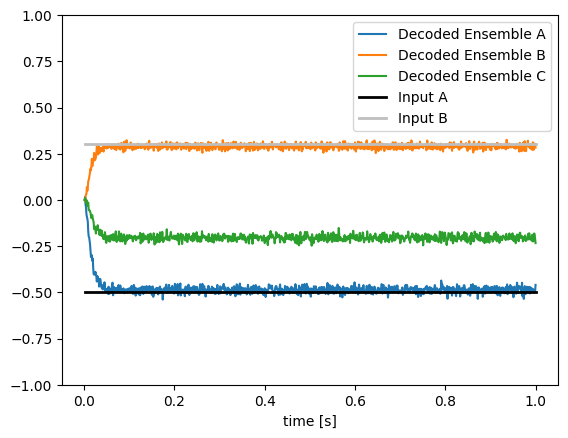

In [2]:

# Create the model object
model = nengo.Network(label="Addition")
with model:
    # Create 3 ensembles each containing 100 leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)
    C = nengo.Ensemble(100, dimensions=1)

with model:
    # Create input nodes representing constant values
    input_a = nengo.Node(output=-0.5)
    input_b = nengo.Node(output=0.3)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(input_a, A)
    nengo.Connection(input_b, B)

    # Connect input ensembles A and B to output ensemble C
    nengo.Connection(A, C)
    nengo.Connection(B, C)

with model:
    input_a_probe = nengo.Probe(input_a)
    input_b_probe = nengo.Probe(input_b)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    C_probe = nengo.Probe(C, synapse=0.01)
    spikesA = nengo.Probe(A.neurons)
    spikesB = nengo.Probe(B.neurons)
    spikesC = nengo.Probe(C.neurons)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(1)

# Plot the input signals and decoded ensemble values
t = sim.trange()
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded Ensemble A")
plt.plot(sim.trange(), sim.data[B_probe], label="Decoded Ensemble B")
plt.plot(sim.trange(), sim.data[C_probe], label="Decoded Ensemble C")
plt.plot(
    sim.trange(), sim.data[input_a_probe], label="Input A", color="k", linewidth=2.0
)
plt.plot(
    sim.trange(), sim.data[input_b_probe], label="Input B", color="0.75", linewidth=2.0
)
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("time [s]")
plt.show()

If this is not intuitive to you, I encourage you to use a single neuron to encode .2 at 100Hz and a single neuron to encode .3 at 100Hz. View your output spikes. Add them together using a third (single) neuron at 100Hz and view the output spikes.

#### Let's talk decoders (again)

Adding is easy! But what if you want to do something a little more complex - say, $(x+y)^2$? This requires us to dive into decoders once more.

Recall (from neuron representation): We multiply our "filtered spike trains" with decoding weights and sum them together to give an estimate of the input based on the spikes (i.e. our decoded signal). The decoding weights assign weights to each neuron output based on how important that is to approximating the signal (i.e. more important = higher amplitude/weight when added together). 

Nengo trains decoding weights - similar to weights of a neural network - that are used to reconstruct the input value via spiking neuron outputs. The decoding weights are determined by minimizing the squared difference between the decoded estimate and the actual input signal. Nengo does this for us and we can get our decoding values from our model. Because weights are trained values between neuron layers, we must get the weights from a connection.

There is a really [helpful video](https://youtu.be/JCA2gOhN5oM?si=S0Pj-T4NoHHfEEuO&t=5576) to understand how these decoder weights can be learned in real-time - great for edge computing. The whole video is great, but this link should start the video at 1hr32min and will explain how decoders are learned in real-time.

### Communication Channel

To solidify our understanding of decoders, let's connect two neuron ensembles together to represent an input signal:  
[Input] ---> (A) ---> (B) ---> [Output]

We will then assess the decoders and decide if it makes sense.

#### Build your model

In [3]:
# Create a 'model' object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Communications Channel")
with model:
    # Create an abstract input signal that oscillates as sin(t)
    sin = nengo.Node(lambda t: np.sin(2*np.pi*t))

    # Create an ouput node to view weights from 2nd ensemble
    out_node = nengo.Node(size_in=1)

    # Create the neuronal ensembles
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)

    # Connect the input to the first neuronal ensemble
    nengo.Connection(sin, A)

    # Connect the first neuronal ensemble to the second
    # (this is the communication channel)
    decoder_connA = nengo.Connection(A, B)

    # Connect the second neuronal ensemble to the output node
    # (this is where decoders for B are stored)
    decoder_connB =nengo.Connection(B, out_node)

#### Add probes to your model

In [4]:
with model:
    sin_probe = nengo.Probe(sin)
    A_probe = nengo.Probe(A, synapse=0.01)  # ensemble output
    B_probe = nengo.Probe(B, synapse=0.01)

#### Run your model

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### View your data

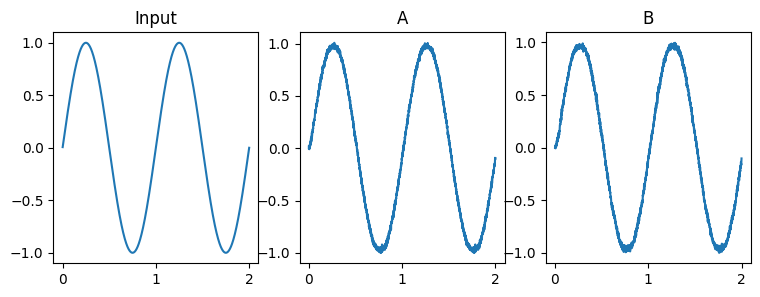

In [6]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.plot(sim.trange(), sim.data[sin_probe])
plt.subplot(1, 3, 2)
plt.title("A")
plt.plot(sim.trange(), sim.data[A_probe])
plt.subplot(1, 3, 3)
plt.title("B")
plt.plot(sim.trange(), sim.data[B_probe])

#### View Decoders

Do you think decoder values for A and B will be the same or different?? Why??

Let's check your intuition:

In [7]:
# probe the weights from the connection between the neuron and output node (out_conn)
with nengo.Simulator(model) as sim:
    decodersA = sim.data[decoder_connA].weights
    decodersB = sim.data[decoder_connB].weights

print(" [  A Decoders   |   B Decoders  ]")
print(np.concatenate((np.transpose(decodersA)[0:20],np.transpose(decodersB)[0:20]), axis=1))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

 [  A Decoders   |   B Decoders  ]
[[-5.36478532e-05  4.34982560e-05]
 [ 8.66182581e-05 -2.58914783e-05]
 [-4.73323236e-05  3.36569695e-05]
 [ 6.12453123e-05 -7.29828977e-05]
 [-6.42004205e-05 -1.32481661e-04]
 [-4.44520711e-05 -7.07240726e-05]
 [-8.26505614e-05 -3.99434125e-05]
 [ 8.50090145e-05 -3.81447330e-05]
 [ 5.08375684e-05 -6.05744086e-05]
 [ 6.02119196e-05 -9.51375079e-05]
 [ 6.00822261e-05 -2.86261716e-05]
 [-7.24778592e-05  4.61968796e-05]
 [ 6.36982931e-05  8.22111093e-05]
 [ 4.37247150e-05 -3.03524525e-05]
 [ 7.45013704e-05 -6.74226986e-05]
 [-1.11452444e-04 -5.61166410e-05]
 [ 7.87496470e-05  3.52154050e-05]
 [ 4.52248494e-05 -2.92346269e-05]
 [-8.39178101e-05 -7.31848507e-05]
 [-9.44712220e-05  3.76011206e-05]]


#### Discussion

Decoder values are computing using least squares, where the decoders minimize the squared difference between the decoded estimate and the actual input signal:

$$<<x-\hat{x}>^2>_x$$

where:

$$\hat{x} = \sum{a_i d_i}$$

with $x$ being the original input signal, $\hat{x}$ being the decoded signal, $a_i$  being neuron activities (i.e. firing rates), and $d_i$ being decoder values.

Now, given that every neuron in a neuron ensemble has randomly set parameters (unless you hand-choose them), we _should not expect the decoders at ensemble A to be equivalent to those at ensemble B_. Suppose our ensemble A parameters are exactly equivalent to ensemble B, then what? Let's see:


In [8]:
# Makes the tuning curves perfectly spaced out
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons) # even spaced from -.9 to .9
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1)) # half care about negative, half positive
    intercepts *= encoders[:, 0]
    return intercepts, encoders

intercepts, encoders = aligned(100)  # Makes evenly spaced intercepts

# Create a 'model' object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Communications Channel 2")
with model:
    # Create an abstract input signal that oscillates as sin(t)
    sin = nengo.Node(lambda t: np.sin(2*np.pi*t))

    # Create an ouput node to view weights from 2nd ensemble
    out_node = nengo.Node(size_in=1)

    # Create the neuronal ensembles
    A = nengo.Ensemble(100,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(100, 100), #evenly distributed between 80 and 100Hz
        encoders=encoders)
    B = nengo.Ensemble(100,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(100, 100), #evenly distributed between 80 and 100Hz
        encoders=encoders)

    # Connect the input to the first neuronal ensemble
    nengo.Connection(sin, A)

    # Connect the first neuronal ensemble to the second
    # (this is the communication channel)
    decoder_connA = nengo.Connection(A, B)

    # Connect the second neuronal ensemble to the output node
    # (this is where decoders for B are stored)
    decoder_connB =nengo.Connection(B, out_node)

    sin_probe = nengo.Probe(sin)
    A_probe = nengo.Probe(A, synapse=0.01)  # ensemble output
    B_probe = nengo.Probe(B, synapse=0.01)

    # probe the weights from the connection between the neuron and output node (out_conn)
with nengo.Simulator(model) as sim:
    decodersA = sim.data[decoder_connA].weights
    decodersB = sim.data[decoder_connB].weights

print(" [  A Decoders   |   B Decoders  ]")
print(np.concatenate((np.transpose(decodersA)[0:20],np.transpose(decodersB)[0:20]), axis=1))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

 [  A Decoders   |   B Decoders  ]
[[ 1.95626762e-04  1.95619126e-04]
 [-9.89656144e-05 -9.83387985e-05]
 [ 1.97321127e-04  1.97518387e-04]
 [-9.50702894e-05 -9.49614368e-05]
 [ 2.01737702e-04  2.01837225e-04]
 [-9.64400719e-05 -9.64402313e-05]
 [ 2.06919683e-04  2.06954902e-04]
 [-1.01092123e-04 -1.00900816e-04]
 [ 2.12203157e-04  2.12269164e-04]
 [-1.07669050e-04 -1.07833345e-04]
 [ 2.17235600e-04  2.17240770e-04]
 [-1.15575369e-04 -1.15662053e-04]
 [ 2.21758797e-04  2.21708823e-04]
 [-1.23713686e-04 -1.23566513e-04]
 [ 2.25890006e-04  2.25880572e-04]
 [-1.31958766e-04 -1.32020490e-04]
 [ 2.29608372e-04  2.29539055e-04]
 [-1.40313260e-04 -1.40231682e-04]
 [ 2.32787742e-04  2.32825588e-04]
 [-1.48163515e-04 -1.48243894e-04]]


The weights are _the same_! However, notice that the decoded signals are a little noiser. This may be becuase we do not adequately span the space of our signal. With more variety of neuron parameters, we can better capture the complexity of the signal.

### Simple computations using neurons and their decoders

So, why did we hit decoders _again_?? 

Encoding and decoding allow us to encode signals over time, and decode transformations of those signals. So far, we've only decoded the signal itself (i.e. a boring but necessary to understand transformation).

Now, we will decode arbitrary transformations of the input signal. These arbitrary transformations are functions performed on our neuron activities (i.e. outputs of the neuron ensembles that encode the input signal). These functions are computed by _learning decoder weights that perform the computation_. This means that if we want to square an input signal, the decoder weights will be learned such that when the filtered neuron spikes are weighted and added up, they'll result in the squared value.

If equations are helpful to you, we now have an output that is $f(x)=x^2$. Nengo learns the encoders in the same way as before, except it's now minimizing the difference between the decoded estimate of $\hat{f}(x)=\hat{x}^2$ and the actual computed value $f(x)=x^2$, where $\hat{x}$ is the encoded input signal and $x$ is the actual input signal:   

$$<<f(x)-\hat{f}(x)>^2>_{x}$$

where:

$$\hat{f}(x) = \sum{a_i d_i}$$

Note: these decoders are learned such that it can handle time-varying input so long as the values used fall within the neuron's radius! This means that regardless of input values, these decoder weights should be used able to effectively decode the function outputs. If it's innacurate, you might just need more neurons.

Enough about that, let’s decode the square of a white noise input:

In [9]:
# Create the model object
model = nengo.Network(label="Squaring")
with model:
    input = nengo.Node(WhiteSignal(1, high=5), size_out=1)
    A = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))

    # connect the input to the neuron ensemble
    nengo.Connection(input, A)

    # probe input node and neuron ensemble
    input_probe = nengo.Probe(input)
    A_spikes = nengo.Probe(A.neurons)


The key here is that we now define a function to be used at a connection. This is how we will square our white noise input.

In [10]:
def square(x):
    return x*x

Now, our connection between our neuron ensemble (encoding the input) and our output node (the final answer) contains the decoders that compute $x^2$. This is completed by adding an argument called `function`.

In [11]:
with model:
    # add an output node
    Asquare = nengo.Node(size_in=1)
    
    # connect the neuron ensemble to the output node with a function
    nengo.Connection(A, Asquare, function=square)

    # probe the output to assess results
    Asquare_probe = nengo.Probe(Asquare, synapse=0.01)

#### Run it

In [12]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### View results

Text(0, 0.5, 'Neuron')

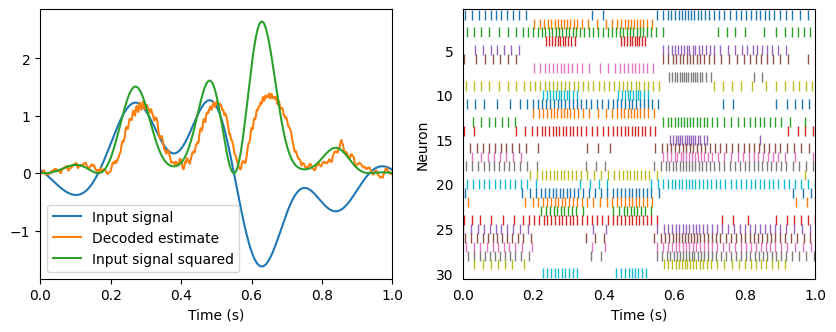

In [13]:

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[Asquare_probe], label="Decoded estimate")
plt.plot(sim.trange(), np.square(sim.data[input_probe]), label="Input signal squared")
plt.legend(loc="best", fontsize="medium")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")


#### Let's check our intuition on decoders once more

I know... hang with me though...

We will add an additional output probe that connects the same ensemble to an output that is just passing data. This means there will be no function associated with the connection, but there will still be trained/learned decoders.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0, 0.5, 'Neuron')

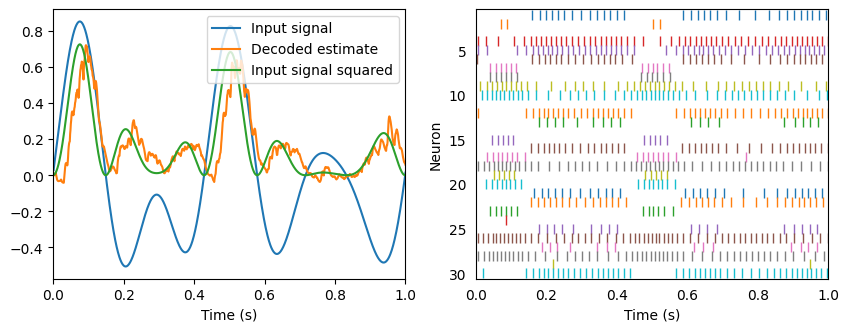

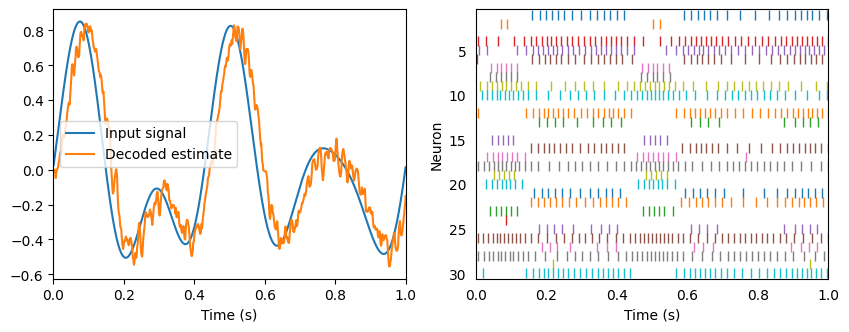

In [14]:
with model:
    # add an output node
    Aoutput = nengo.Node(size_in=1)
    
    # connect the neuron ensemble to the output node WITHOUT a function
    nengo.Connection(A, Aoutput)

    # probe the output to assess results
    Aout_probe = nengo.Probe(Aoutput, synapse=0.01)


with nengo.Simulator(model) as sim:
    sim.run(1)


plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[Asquare_probe], label="Decoded estimate")
plt.plot(sim.trange(), np.square(sim.data[input_probe]), label="Input signal squared")
plt.legend(loc="best", fontsize="medium")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[Aout_probe], label="Decoded estimate")
plt.legend(loc="best", fontsize="medium")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")


Notice that the spike trains are exactly the same!! The only difference is how we’re interpreting those spikes. We told Nengo to compute two sets of decoders, one that estimates the function $x^2$ and one that estimates the input signal.

In general, the transformation principle determines how we can decode spike trains to compute linear and nonlinear transformations of signals encoded in a population of neurons. We can then project those transformed signals into another population, and repeat the process. This means we can use the same neuron ensemble output and do many different things to it in parallel by connecting it to different nodes / ensembles with different weights. This will come in quite handy when we start mapping algorithms to neurons.

**Your turn! Try changing your function and see how well it works.**

### Computations with 2-dimensional neurons

You may have noticed that you can only generate functions using the above model if it involves a single input. Recall addition - we had 2 inputs but we didn't need any distinction between the two. What if instead you wanted to compute $x^2+y$? We can do $x^2$ using the above model, but how do we ensure we square only the input $x$ and not $y$?? 

2D neurons can keep the two values separate as they enter the ensemble. One dimension is used for the first input $x$, the other for the second input $y$. Then, you can learn decoders for a function $f(x,y)=x^2+y$ between the 2D ensemble and whatever is next.

We will do multiplication of a piecewise function to show how this works. 

#### Build your model

In [15]:
# Create the model object
model = nengo.Network(label="Multiplication")
with model:

    # Create a piecewise step function for input
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 1, 4: -1}))
    inputB = nengo.Node(Piecewise({0: 1, 1.5: .2, 3: 0, 4.5: .2}))

    correct_ans = Piecewise({0: 0, 1.5: 0, 2.5: .2, 3: 0, 4: 0, 4.5: -.2})

    # Create 4 ensembles of leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)
    combined = nengo.Ensemble(220, dimensions=2)  
    prod = nengo.Ensemble(100, dimensions=1)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)

    # Connect input ensembles A and B to the 2D combined ensemble
    nengo.Connection(A, combined[0])
    nengo.Connection(B, combined[1])

    # Define a function that computes the multiplication of two inputs
    def product(x):
        return x[0] * x[1]

    # Connect the combined ensemble to the output ensemble D
    nengo.Connection(combined, prod, function=product)

#### Probe all the things and run it!

In [16]:
with model:
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(combined, synapse=0.01)
    prod_probe = nengo.Probe(prod, synapse=0.01)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot results

(-1.1, 1.1)

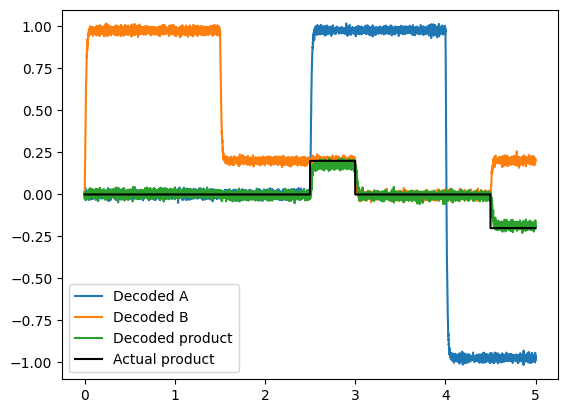

In [17]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt), c="k", label="Actual product"
)
plt.legend(loc="best")
plt.ylim(-1.1, 1.1)

What if we wanted to use values greater than 1?? Let's take a look at our Nengo GUI!

In your terminal, type `nengo`. This will launch a web browser with (hopefully) a ready to go default simulation file. We are going to take a look at what happens when we start working with values greater than 1 and how to deal with 2-D neurons as their values also increase.

Just kidding! My new laptop won't launch it. WHOMP. You can see a video of we are about to do using NengoGUI [here](https://youtu.be/zo8I_NtHtWI?si=JuYQAPfAg6Inkfla&t=3967). It's very helpful!

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(-1.1, 1.1)

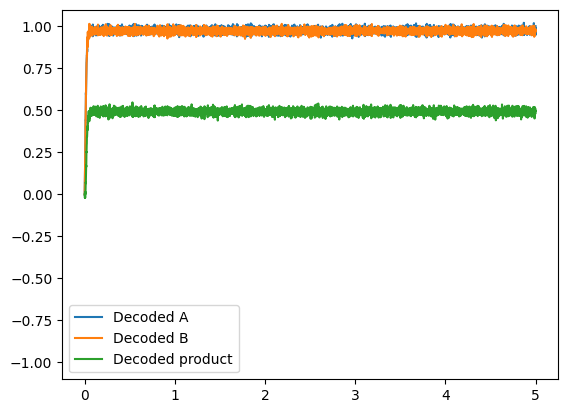

In [18]:
# Define a function that computes the multiplication of two inputs
def product(x):
    return x[0] * x[1]

# Create the model object
model = nengo.Network(label="BadMath")
with model:

    # Create a piecewise step function for input
    inputA = nengo.Node(1)
    inputB = nengo.Node(1)

    correct_ans = 1

    # Create 4 ensembles of leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)
    combined = nengo.Ensemble(220, dimensions=2)  
    prod = nengo.Ensemble(100, dimensions=1)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)

    # Connect input ensembles A and B to the 2D combined ensemble
    nengo.Connection(A, combined[0])
    nengo.Connection(B, combined[1])

    # Connect the combined ensemble to the output ensemble D
    nengo.Connection(combined, prod, function=product)

with model:
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(combined, synapse=0.01)
    prod_probe = nengo.Probe(prod, synapse=0.01)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.legend(loc="best")
plt.ylim(-1.1, 1.1)    

#### Computations with 2-dimensional neurons, again

Here, we repeat our multiplication, but with values greater than 1.

Note the radii defined for each neuron ensemble. For the 1D neurons, you set the radius to your known max value, $10$. For the 2D neuron, you need to think of your possible values as a "unit square", resulting in the max value of the 2D neuron ($\sqrt{10}+\sqrt{10}$).

#### Build your model

In [19]:
# Create the model object
model = nengo.Network(label="Multiplication 2")
with model:

    # Create a piecewise step function for input
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 10, 4: -10}))
    inputB = nengo.Node(Piecewise({0: 10, 1.5: 2, 3: 0, 4.5: 2}))

    correct_ans = Piecewise({0: 0, 1.5: 0, 2.5: 20, 3: 0, 4: 0, 4.5: -20})

    # Create 4 ensembles of leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1, radius=10)
    B = nengo.Ensemble(100, dimensions=1, radius=10)
    combined = nengo.Ensemble(
        220, dimensions=2, radius=15
    )  # This radius is ~sqrt(10^2+10^2)
    prod = nengo.Ensemble(100, dimensions=1, radius=20)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)

    # Connect input ensembles A and B to the 2D combined ensemble
    nengo.Connection(A, combined[0])
    nengo.Connection(B, combined[1])

    # Define a function that computes the multiplication of two inputs
    def product(x):
        return x[0] * x[1]

    # Connect the combined ensemble to the output ensemble D
    nengo.Connection(combined, prod, function=product)

#### Probe all the things and run it!

In [20]:
with model:
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(combined, synapse=0.01)
    prod_probe = nengo.Probe(prod, synapse=0.01)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Plot Results

(-25.0, 25.0)

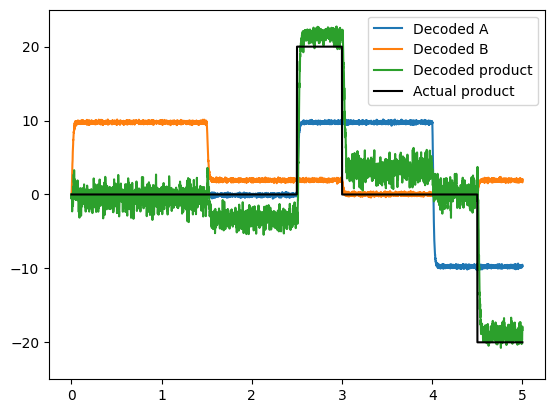

In [21]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt), c="k", label="Actual product"
)
plt.legend(loc="best")
plt.ylim(-25, 25)

#### Your Turn

Using everything we've learned, implement the function $f(x,y)=x^2+y$ using neurons. If you choose to use values greater than 1, choose your neuron radii accordingly.